<a href="https://colab.research.google.com/github/Ravitejaa249/DIP-project/blob/main/DWT_Xception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import cv2
import numpy as np
!pip install PyWavelets
import pywt
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Configuration
IMAGE_SIZE = (299, 299)
BATCH_SIZE = 32
EPOCHS = 10  # Increased epochs with early stopping
DWT_SUBBANDS = ['LL', 'LH', 'HL']

def apply_dwt(image):
    """Apply DWT and return 3-channel normalized subbands"""
    if len(image.shape) > 2:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    coeffs = pywt.dwt2(image, 'haar')
    LL, (LH, HL, HH) = coeffs

    normalized = []
    for band in [LL, LH, HL]:
        band = band.astype(np.float32)
        band = (band - np.min(band)) / (np.max(band) - np.min(band) + 1e-8)
        band = cv2.resize(band, IMAGE_SIZE, interpolation=cv2.INTER_CUBIC)
        normalized.append(band)

    return np.stack(normalized, axis=-1)

def load_and_preprocess_images(directory, label, max_samples=1000):
    images = []
    labels = []
    filenames = os.listdir(directory)
    np.random.shuffle(filenames)  # Shuffle before limiting samples

    for filename in filenames[:max_samples]:
        img = cv2.imread(os.path.join(directory, filename))
        if img is None:
            continue
        img = cv2.resize(img, IMAGE_SIZE)
        dwt_img = apply_dwt(img)
        images.append(dwt_img)
        labels.append(label)

    return np.array(images), np.array(labels)

# Load and preprocess data
print("Loading data...")
real_dir = '/content/drive/MyDrive/AI-face-detection-Dataset/real'
fake_dir = '/content/drive/MyDrive/AI-face-detection-Dataset/AI'

X_real, y_real = load_and_preprocess_images(real_dir, 0)
X_fake, y_fake = load_and_preprocess_images(fake_dir, 1)

# Combine and split data
X = np.concatenate([X_real, X_fake])
y = np.concatenate([y_real, y_fake])

print("Class distribution:")
print(f"Real samples: {np.sum(y == 0)}")
print(f"Fake samples: {np.sum(y == 1)}")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    zoom_range=0.2
)

# Build model
input_tensor = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_model = Xception(
    include_top=False,
    weights='imagenet',
    input_tensor=input_tensor,
    pooling='avg'
)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Dense(256, activation='relu', kernel_regularizer='l2')(x)  # Reduced units + L2
x = Dropout(0.6)(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_tensor, outputs=predictions)

# Compile with learning rate decay
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)

# Train model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=EPOCHS,
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight={0: 1, 1: np.sum(y_train == 0)/np.sum(y_train == 1)},
    steps_per_epoch=len(X_train) // BATCH_SIZE
)

# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'\nTest Accuracy: {test_acc:.4f}')

# Unfreeze some layers for fine-tuning
print("Unfreezing layers for fine-tuning...")
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Recompile with lower learning rate
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Continue training
history_fine = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=20,  # Additional fine-tuning epochs
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr],
    class_weight={0: 1, 1: np.sum(y_train == 0)/np.sum(y_train == 1)},
    steps_per_epoch=len(X_train) // BATCH_SIZE
)

# Final evaluation
final_loss, final_acc = model.evaluate(X_test, y_test)
print(f'\nFinal Test Accuracy: {final_acc:.4f}')

# Save model
model.save('deepfake_detection_dwt_xception.h5')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 61.5 MB/s eta 0:00:00
Loading data...
Class distribution:
Real samples: 1000
Fake samples: 1000
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.6452 - loss: 4.9998 - val_accuracy: 0.9550 - val_loss: 4.1668 - learning_rate: 1.0000e-04
Epoch 2/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 45s 908ms/step - accuracy: 0.9062 - loss: 4.0232 - val_accuracy: 0.9600 - val_loss: 3.4001 - learning_rate: 1.0000e-04
Epoch 3/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.9305 - loss: 3.3128 - val_accuracy: 0.9675 - val_loss: 2.8057 - learning_rate: 1.0000e-04
Epoch 4/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 48s 951ms/step - accuracy: 0.9320 - loss: 2.7644 - val_accuracy: 0.9625 - val_loss: 2.3395 - learning_rate: 1.0000e-04
Epoch 5/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 83s 957ms/step - accuracy: 0.9423 - loss: 2.3012 - val_accuracy: 0.9750 - val_loss: 1.9415 - learning_rate: 1.0000e-04
Epoch 6/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 79s 914ms/step - accuracy: 0.9416 - loss: 1.9295 - val_accuracy: 0.9750 - val_loss: 1.6315 - learning_rate: 1.0000e-04
Epoch 7/10
50/50 ━━━━━━━━━━━━━━━━━━━━ 50s 1s/step - accuracy: 0.


Final Test Accuracy: 0.9975


13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 454ms/step
Accuracy: 0.9975 | Precision: 1.0000 | Recall: 0.9950 | F1-Score: 0.9975 | AUC: 0.9999


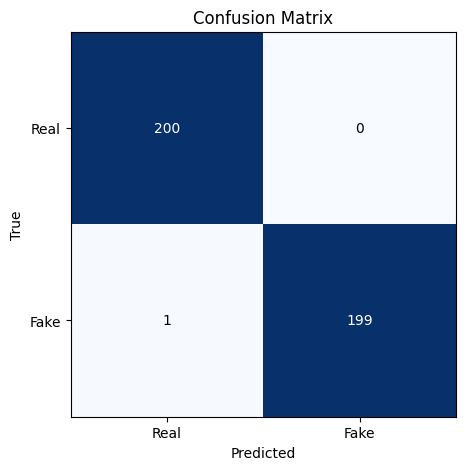

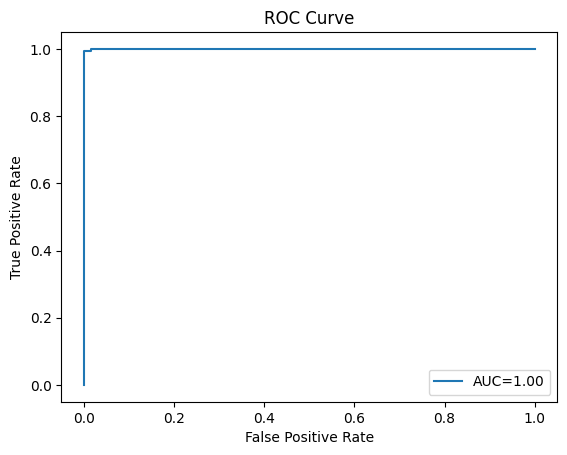

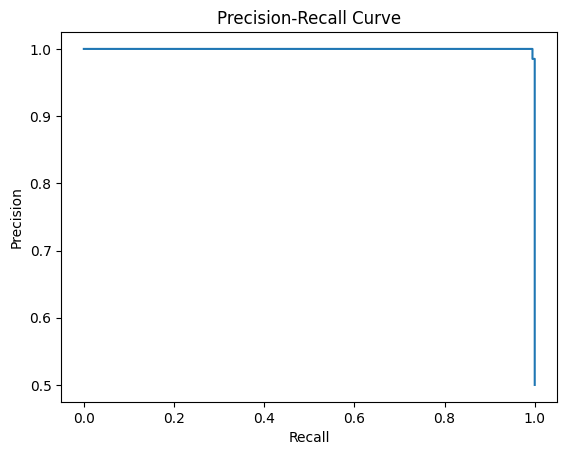

In [ ]:
# === 5.1–5.4 Metrics & Visualizations ===

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
)
import matplotlib.pyplot as plt
import numpy as np

# Generate predictions on the held-out test set
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob >= 0.5).astype(int)

# 5.1 Metrics Used
acc  = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec  = recall_score(y_test, y_pred)
f1   = f1_score(y_test, y_pred)
auc  = roc_auc_score(y_test, y_prob)
print(f"Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1-Score: {f1:.4f} | AUC: {auc:.4f}")

# 5.2 Confusion Matrix Analysis
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
for (i, j), val in np.ndenumerate(cm):
    plt.text(j, i, val, ha='center', va='center',
             color='white' if val > cm.max()/2 else 'black')
plt.xticks([0,1], ['Real','Fake'])
plt.yticks([0,1], ['Real','Fake'])
plt.show()

# 5.3 ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC={auc:.2f}")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.show()

# 5.4 Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_test, y_prob)
plt.figure()
plt.plot(recall_vals, precision_vals)
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()
